<a href="https://colab.research.google.com/github/khoualdiafarouk/Predicting-tags-for-Stackoverflow/blob/main/Tag_prediction_Stackoverflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




```

```

# Predicting tokens for stack overflow

In [ ]:
from ast import literal_eval
import pandas as pd
import numpy as np


In [ ]:
def read_data(file):
  data=pd.read_csv(file,sep='\t')
  data['tags']=data['tags'].apply(literal_eval)
  return data


In [ ]:
train=read_data('data/train.tsv')
validation=read_data('data/validation.tsv')
test=pd.read_csv('data/test.tsv',sep='\t')

In [ ]:
train.head

<bound method NDFrame.head of                                                    title                                     tags
0                    How to draw a stacked dotplot in R?                                      [r]
1      mysql select all records where a datetime fiel...                             [php, mysql]
2                 How to terminate windows phone 8.1 app                                     [c#]
3      get current time in a specific country via jquery                     [javascript, jquery]
4                          Configuring Tomcat to Use SSL                                   [java]
...                                                  ...                                      ...
99995  Obj-c, incorrect checksum for freed object - o...  [iphone, objective-c, ios, cocoa-touch]
99996              How to connect via HTTPS using Jsoup?                          [java, android]
99997  Python Pandas Series of Datetimes to Seconds S...               [python, datetime

In [ ]:
X_train=train['title'].values
y_train=train['tags'].values
X_val=validation['title'].values
y_val=validation['tags'].values
X_test=test['title'].values

In [ ]:
import re


In [ ]:
from nltk.tokenize import word_tokenize
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub('',text)
    text = BAD_SYMBOLS_RE.sub('',text)
    text_tokens=word_tokenize(text)
    words=[word for word in text_tokens if word not in STOPWORDS]
    text=' '.join(words)
    return text

In [ ]:
X_train=[text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [ ]:
X_train[:3]


['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

In [ ]:
tags_counts = {}
for tags in y_train:
  for tag in tags:
    if tag not in tags_counts:
      tags_counts[tag]=1
    else:
      tags_counts[tag]+=1
words_counts = {}
for words in X_train:
    words=words.split()
    for word in words:
      if word not in words_counts:
        words_counts[word]=1
      else:
        words_counts[word]+=1 
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]
print(most_common_tags)
print(most_common_words)

[('javascript', 19078), ('c#', 19077), ('java', 18661)]
[('using', 8274), ('c', 5610), ('php', 5422)]


Transforming text to a vector

1-Bag of words :

In [207]:
DICT_SIZE = 5000
WORDS_DICT=sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = dict(zip(WORDS_DICT,range(DICT_SIZE)))
INDEX_TO_WORDS = dict(zip(range(DICT_SIZE),WORDS_DICT))
ALL_WORDS = WORDS_TO_INDEX.keys()
def my_bag_of_words(text, words_to_index, dict_size):
    result_vector = np.zeros(dict_size)
    for word in text.split ():
        if word in words_to_index.keys():
            result_vector [words_to_index[word]] += 1
    return result_vector

In [ ]:
from scipy import sparse as sp_sparse


In [ ]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


2-tf-idf


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def tfidf_features(X_train, X_val, X_test):
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),max_df=0.9,min_df=5,token_pattern=r'(\S+)' )
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val= tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train,X_val, X_test, tfidf_vectorizer.vocabulary_


In [ ]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

MultiLabel classifier

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer


In [ ]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [ ]:
mlb.classes_

array(['.net', 'ajax', 'algorithm', 'android', 'angularjs', 'apache',
       'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'class',
       'cocoa-touch', 'codeigniter', 'css', 'csv', 'database', 'date',
       'datetime', 'django', 'dom', 'eclipse', 'entity-framework',
       'excel', 'facebook', 'file', 'forms', 'function', 'generics',
       'google-maps', 'hibernate', 'html', 'html5', 'image', 'ios',
       'iphone', 'java', 'javascript', 'jquery', 'json', 'jsp', 'laravel',
       'linq', 'linux', 'list', 'loops', 'maven', 'mongodb',
       'multithreading', 'mysql', 'node.js', 'numpy', 'objective-c',
       'oop', 'opencv', 'osx', 'pandas', 'parsing', 'performance', 'php',
       'pointers', 'python', 'python-2.7', 'python-3.x', 'qt', 'r',
       'regex', 'rest', 'ruby', 'ruby-on-rails', 'ruby-on-rails-3',
       'selenium', 'servlets', 'session', 'sockets', 'sorting', 'spring',
       'spring-mvc', 'sql', 'sql-server', 'string', 'swift', 'swing',
       'twitter-bootstrap'

In [ ]:
# For multiclass classification
from sklearn.multiclass import OneVsRestClassifier

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier

def train_classifier(X_train, y_train, X_valid=None, y_valid=None, C=1.0, model='lr'):
    """
      X_train, y_train — training data
      
      return: trained classifier
      
    """
    
    if model=='lr':
        model = LogisticRegression(C=C, penalty='l1', dual=False, solver='liblinear')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='svm':
        model = LinearSVC(C=C, penalty='l1', dual=False, loss='squared_hinge')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='nbayes':
        model = MultinomialNB(alpha=1.0)
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
        
    elif model=='lda':
        model = LinearDiscriminantAnalysis(solver='svd')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)

    return model

# Train the classifiers for different data transformations: bag-of-words and tf-idf.

# Linear NLP model using bag of words approach
%time classifier_mybag = train_classifier(X_train_mybag, y_train, C=1.0, model='lr')

# Linear NLP model using TF-IDF approach
%time classifier_tfidf = train_classifier(X_train_tfidf, y_train, C=1.0, model='lr')

CPU times: user 8.67 s, sys: 43.4 ms, total: 8.71 s
Wall time: 8.72 s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CPU times: user 1min 48s, sys: 67.2 ms, total: 1min 48s
Wall time: 1min 48s


In [ ]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [ ]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_mybag)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(10):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype applicationjson required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	


Title:	library found
True labels:	c++,ios,iphone,xcode
Predicted labels:	


Title:	csproj file programmatic addingdeleting files
True labels:	c#
Predicted labels:	


Title:	typeerror makedirs got unexpected keyword argument exists_ok
True labels:	django,python
Predicted labels:	


Title:	pan div using jquery
True labels:	html,javascript,jquery
Predicted labels:	


Title:	hibernate intermediateadvanced tutorials
True labels:	hibernate,java
Predicted labels:	




Evaluation

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from functools import partial

def print_evaluation_scores(y_val, predicted):
    f1_score_macro = partial(f1_score,average="macro")
    f1_score_micro = partial(f1_score,average="micro")
    f1_score_weighted = partial(f1_score,average="weighted")
    
    average_precision_score_macro = partial(average_precision_score,average="macro")
    average_precision_score_micro = partial(average_precision_score,average="micro")
    average_precision_score_weighted = partial(average_precision_score,average="weighted")
    
    scores = [accuracy_score,f1_score_macro,f1_score_micro,f1_score_weighted,average_precision_score_macro,
             average_precision_score_micro,average_precision_score_weighted]
    for score in scores:
        print(score,score(y_val,predicted))

print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)


Bag-of-words
<function accuracy_score at 0x7f7e72b3f598> 0.0
functools.partial(<function f1_score at 0x7f7e72b3f9d8>, average='macro') 0.0
functools.partial(<function f1_score at 0x7f7e72b3f9d8>, average='micro') 0.0
functools.partial(<function f1_score at 0x7f7e72b3f9d8>, average='weighted') 0.0
functools.partial(<function average_precision_score at 0x7f7e72b30510>, average='macro') 0.01950333333333333
functools.partial(<function average_precision_score at 0x7f7e72b30510>, average='micro') 0.019503333333333334
functools.partial(<function average_precision_score at 0x7f7e72b30510>, average='weighted') 0.08404558878824134
Tfidf
<function accuracy_score at 0x7f7e72b3f598> 0.3619
functools.partial(<function f1_score at 0x7f7e72b3f9d8>, average='macro') 0.505616032651385
functools.partial(<function f1_score at 0x7f7e72b3f9d8>, average='micro') 0.6705180533751962
functools.partial(<function f1_score at 0x7f7e72b3f9d8>, average='weighted') 0.6480304194388395
functools.partial(<function avera

In [ ]:
from metrics import roc_auc
%matplotlib inline

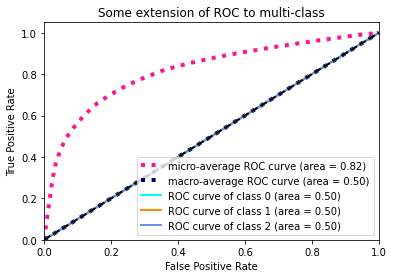

In [ ]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

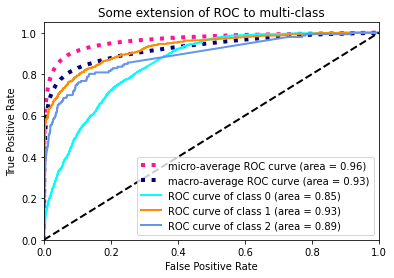

In [ ]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)